In [1]:
import sys
sys.path.insert(0, "..//..//..//scripts")

import xgboost as xgb
import seaborn as sns
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from NonParametricClassifier import *
from CDFClassifier import *
from NaiveBayesPrep import *
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [2]:
df = pd.read_csv("..//..//..//..//data//Weekly_data_tokenized.csv")

In [3]:
def grid_search(x, y, num, clf, train, test, classes, compare, useprior):
    
    grid = {}
    grid2 = {}

    for n in np.linspace(x, y, num)[1:]:
        tclf = clf(alpha = float(n), compare = compare, useprior = useprior)
        tclf.fit(train, classes)
        grid.update({n: confusion_matrix(tclf.predict(test, classes), tclf.test_Y)})
        grid2.update({n: np.diag(grid[n]).sum() / grid[n].sum()})
    
    best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
    print("Best accuracy:", best[1])
    print("Parameter", best[0])

    plt.plot([i for i in grid2], [grid2[i] for i in grid2])
    
    return grid2

def create_genre(row, genre):
    if re.search(genre, row["Genre"], flags = re.I) != None:
        return 1
    else:
        return 0

df["Pop"] = df.apply(lambda row: create_genre(row, "pop"), axis = 1)
df["Rap"] = df.apply(lambda row: create_genre(row, "rap"), axis = 1)

df = df[["word", "ID", "Pop", "Rap"]]

In [4]:
np.random.seed(1)

IDs = df.ID.unique()
np.random.shuffle(IDs)

train = df[df.ID.isin(IDs[:int(.8 * len(IDs))])]
test = df[df.ID.isin(IDs[int(.8 * len(IDs)):])]

## KL Divergence

In [5]:
klgrid = grid_search(0.00000001, 0.0001, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "KL", False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Hellinger

In [ ]:
hellingergrid = grid_search(0, 5, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "hellinger", False)

## Mann-Whitney

In [ ]:
def grid_search(x, y, num, clf, train, test, classes, compare):
    
    grid = {}
    grid2 = {}

    for n in np.linspace(x, y, num):
        tclf = clf(alpha = n, compare = compare)
        tclf.fit(train, classes)
        grid.update({n: confusion_matrix(tclf.predict(test, classes), tclf.test_Y)})
        grid2.update({n: np.diag(grid[n]).sum() / grid[n].sum()})
        
    best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
    print("Best accuracy:", best[1])
    print("Parameter", best[0])

    plt.plot([i for i in grid2], [grid2[i] for i in grid2])

In [ ]:
mwgrid = grid_search(0.01, 2, 200, CDFClassifier, train, test, ["Pop", "Rap"], "Mann-Whitney");

## Naive Bayes - Bernoulli

In [8]:
X_train, y_train, X_test, y_test = prepare_data(train, test)

In [ ]:
bernoulligrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = BernoulliNB(alpha = n)
    clf.fit(X_train, y_train)
    bernoulligrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(bernoulligrid[n]).sum() / bernoulligrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

## Naive Bayes - Multinomial

Best accuracy: 0.8305343511450382
Parameter 0.5714285714285714


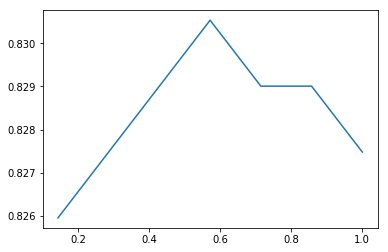

In [12]:
multigrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = MultinomialNB(alpha = n)
    clf.fit(X_train, y_train)
    multigrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(multigrid[n]).sum() / multigrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

## xgboost

In [ ]:
def convert_genre(y):
    y = np.array(y)
    counts = Counter(y)
    itor = 0
    for genre in counts:
        y[y == genre] = itor
        itor += 1
    return y.astype(int)

In [ ]:
y_train_binary = convert_genre(y_train)
y_test_binary = convert_genre(y_test)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train_binary)
dtest = xgb.DMatrix(X_test, label = y_test_binary)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

grid = {}
dims = 10

for l1 in np.linspace(0, 1, dims):
    for l2 in np.linspace(0, 1, dims):   
        param = {'max_depth': 1000, 'eta': 0.2, 'silent': 1, 'objective': 'binary:logistic', "alpha": l1,
                 "lambda": l2, "subsample": 0.9}
        bst = xgb.train(params = param, dtrain = dtrain, num_boost_round = 200, evals = evallist, early_stopping_rounds = 50)
        cfmat = confusion_matrix(bst.predict(dtest).round(), y_test_binary)
        grid.update({(l1, l2): np.diag(cfmat).sum() / cfmat.sum()})

In [ ]:
mat = np.zeros((dims, dims))
row = 0
col = 0
for (r, c) in grid:
    mat[row, col] = grid[(r, c)]
    col += 1
    if (col) % dims == 0:
        if (row, col) == (0, 1):
            continue
        col = 0
        row += 1

In [ ]:
fig = plt.figure(figsize = (10, 8))
sns.heatmap(mat, annot = True, fmt = ".3f");